# Identifying active irrigated cropping

* **Products used:** 
[ls8_st](https://explorer.digitalearth.africa/ls8_st), 
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr), 
[crop_mask_sahel](https://explorer.digitalearth.africa/crop_mask_sahel), 
[ERA5 Climate Data](https://registry.opendata.aws/ecmwf-era5/)


## Background

One of the well-known measures of plant health is canopy temperature. In conditions with limited water, it can be assumed transpiration decreases and plant temperature subsequently increases. 

In the field, canopy temperatures can be measured by handheld radiometers. This sort of data is used at a small scale to examine crop health and yield under a variety of conditions. At larger scales, an alternative method is to use surface temperature detected by satellites such as Landsat 8 to calculate similar metrics. In this notebook, we will investigate the Crop Water Stress Index.

Jackson, Kustas and Choudhury (1988) refer to the Crop Water Stress Index (CWSI) as:

\begin{equation}
\text{CWSI} = \frac{\left(T_c - T_a\right) - \left( T_c - T_a \right)_{ll}}{\left(T_c - T_a\right) - \left( T_c - T_a \right)_{ul}}
\end{equation}

where

* $T_c$ is crop temperature
* $T_a$ is air temperature
* $ll$ stands for *lower limit* of the temperature difference
* $ul$ stands for *upper limit* of the temperature difference



Low CWSI indicates less crop water stress, while high CWSI indicates high stress.

For theoretical estimations, $\Delta T_{ul}$ and $\Delta T_{ll}$ are calculated from the energy balance equation and an assortment of esoteric measurements including aerodynamic resistance. In practice, Jackson et al state: 
> The purpose of the upper and lower limits is to form bounds by which the measured temperature can be normalised.

In this case, we will use measurements of air temperature modelled by ERA5 to approximate $T_a$ and the Landsat surface temperature product to approximate $T_c$. This allows us to estimate CWSI.

## Description
In this notebook, we calculate Crop Water Stress Index (CWSI) and visualise over irrigated areas.

The following steps are taken:

1. Load Landsat 8 Surface Temperature data
2. Load ERA5 "Air temperature at 2 metres" data for the same area of interest
3. Calculate CWSI
4. Visualise CWSI
5. Compare CWSI and NDVI visualisation
6. Restrict analysis to cropland
7. Compare CWSI and NDVI trends
8. Identify water-stressed fields

***

## Load packages

In [23]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from odc.algo import xr_reproject
from skimage.filters import threshold_li
from matplotlib.colors import ListedColormap

from deafrica_tools.load_era5 import load_era5
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Landsat_ST_CWSI")

### Analysis parameters

This analysis focuses on cropland in Sudan. The western portion of the area of interest appear irrigated, as it is serviced by canals on close inspection, and vegetation is greener than surrounding landscape features. The eastern portion of the area is mostly dryland/rainfed cropping.

In [3]:
lon = 33.822#-8.0766 #30.379 
lat = 13.8489#33.073
buffer = 0.125

lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

time = ('2019-06', '2019-11')

measurements = ['surface_temperature']

### View selected location

In [4]:
display_map(lon_range, lat_range)

## Load Landsat 8 Surface Temperature data

In [6]:
ds_land = load_ard(dc=dc,
               products=['ls8_st'],
               x=lon_range,
               y=lat_range,
               time=time,
               measurements=measurements,
               skip_broken_datasets=True,
               output_crs='EPSG:6933',
               mask_filters=[("opening", 5),("dilation", 5)], #improve cloud-mask
               resolution=(-30, 30))

print(ds_land)

Error opening source dataset: s3://deafrica-landsat/collection02/level-2/standard/oli-tirs/2019/172/051/LC08_L2SP_172051_20190707_20200827_02_T1/LC08_L2SP_172051_20190707_20200827_02_T1_QA_PIXEL.TIF
Ignoring Exception: '/vsis3/deafrica-landsat/collection02/level-2/standard/oli-tirs/2019/172/051/LC08_L2SP_172051_20190707_20200827_02_T1/LC08_L2SP_172051_20190707_20200827_02_T1_QA_PIXEL.TIF' not recognized as a supported file format.
Error opening source dataset: s3://deafrica-landsat/collection02/level-2/standard/oli-tirs/2019/172/051/LC08_L2SP_172051_20190707_20200827_02_T1/LC08_L2SP_172051_20190707_20200827_02_T1_QA_PIXEL.TIF
Ignoring Exception: '/vsis3/deafrica-landsat/collection02/level-2/standard/oli-tirs/2019/172/051/LC08_L2SP_172051_20190707_20200827_02_T1/LC08_L2SP_172051_20190707_20200827_02_T1_QA_PIXEL.TIF' not recognized as a supported file format.


Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_st
Applying morphological filters to pq mask [('opening', 5), ('dilation', 5)]
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 24 time steps
<xarray.Dataset>
Dimensions:              (time: 24, y: 1034, x: 805)
Coordinates:
  * time                 (time) datetime64[ns] 2019-06-05T08:03:16.927509 ......
  * y                    (y) float64 1.766e+06 1.766e+06 ... 1.735e+06 1.735e+06
  * x                    (x) float64 3.251e+06 3.251e+06 ... 3.275e+06 3.275e+06
    spatial_ref          int32 6933
Data variables:
    surface_temperature  (time, y, x) float32 nan nan nan ... 324.6 324.5 324.4
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


### Convert to celsius and resample to annual means

In [7]:
# convert from Kelvin to Celsius
ds_land['surface_temperature'] = ds_land.surface_temperature - 273.15

#Annual surfce land temp
ds_land = ds_land.mean('time')

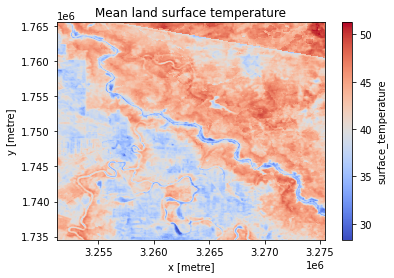

In [8]:
#plot
ds_land.surface_temperature.plot.imshow(cmap='coolwarm')
plt.title('Mean land surface temperature');

## Load ERA5 Air Temperature data

In [9]:
# load ERA5 air temperature at 2m height, resampled to daily means
var = 'air_temperature_at_2_metres'
ds_air = load_era5(var, lat_range, lon_range, time, resample='1M', reduce_func=np.mean)[var] - 273.15
ds_air = ds_air.compute() #bring into memory

#rename dimensions to match landsat
ds_air = ds_air.rename({'lon': 'x','lat': 'y'})

#Seasonal mean air temp
ds_air = ds_air.mean('time')

The above plots show the data has loaded correctly. ERA5 temporal resolution is higher than Landsat 8, which accounts for the greater fluctuation. It is also expected that land temperature will be higher than 2 metre air temperature. 

Note the land temperature estimated by Landsat 8 can seem quite high; here, it is shown in excess of 40 degrees Celsius. In this notebook, we do not have the means to validate the dataset so it is difficult to tell if the readings are accurate, or exaggerated due to inherent instrumentation error. Regardless, this is mitigated by the CWSI calculation, which looks at the difference between temperatures instead of absolute values.

## Calculate Ts - Ta

As noted in the introduction, for this exercise we estimate Crop Water Stress Index using the loaded temperature datasets in lieu of in-situ data. This can be broken down into the following steps:

1. Reproject air temperature to match the resolution of Landsat
2. Find the difference $\Delta T$ between $T_c$ (land temperature) and $T_a$ (air temperature)


In [10]:
ds_air = xr_reproject(src=ds_air, geobox=ds_land.geobox, resampling="nearest")

Calculate $\Delta T$:

In [11]:
deltat = ds_land.surface_temperature - ds_air

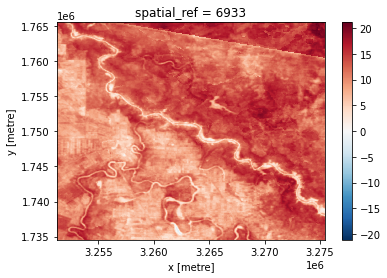

In [12]:
deltat.plot.imshow();

## Load Landsat-8 Surface Reflectance data and calculate NDVI

In [13]:
ds_ndvi = load_ard(dc=dc,
               products=['ls8_sr'],
               like=ds_land.geobox,
               time=time,
               skip_broken_datasets=True,
               measurements =['red', 'nir'])

ds_ndvi = calculate_indices(ds_ndvi, index='NDVI', collection = 'c2', drop=True)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr


Error opening source dataset: s3://deafrica-landsat/collection02/level-2/standard/oli-tirs/2019/172/051/LC08_L2SP_172051_20190707_20200827_02_T1/LC08_L2SP_172051_20190707_20200827_02_T1_QA_PIXEL.TIF
Ignoring Exception: '/vsis3/deafrica-landsat/collection02/level-2/standard/oli-tirs/2019/172/051/LC08_L2SP_172051_20190707_20200827_02_T1/LC08_L2SP_172051_20190707_20200827_02_T1_QA_PIXEL.TIF' not recognized as a supported file format.
Error opening source dataset: s3://deafrica-landsat/collection02/level-2/standard/oli-tirs/2019/172/051/LC08_L2SP_172051_20190707_20200827_02_T1/LC08_L2SP_172051_20190707_20200827_02_T1_QA_PIXEL.TIF
Ignoring Exception: '/vsis3/deafrica-landsat/collection02/level-2/standard/oli-tirs/2019/172/051/LC08_L2SP_172051_20190707_20200827_02_T1/LC08_L2SP_172051_20190707_20200827_02_T1_QA_PIXEL.TIF' not recognized as a supported file format.


Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 24 time steps
Dropping bands ['red', 'nir']


In [14]:
ds_ndvi = ds_ndvi.max('time').squeeze()
print(ds_ndvi)

<xarray.Dataset>
Dimensions:      (y: 1034, x: 805)
Coordinates:
  * y            (y) float64 1.766e+06 1.766e+06 ... 1.735e+06 1.735e+06
  * x            (x) float64 3.251e+06 3.251e+06 ... 3.275e+06 3.275e+06
    spatial_ref  int32 6933
Data variables:
    NDVI         (y, x) float32 0.219 0.2188 0.197 ... 0.3944 0.4339 0.5525


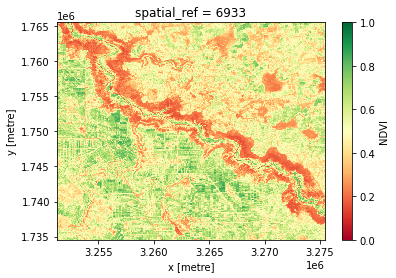

In [15]:
ds_ndvi.NDVI.plot.imshow(cmap='RdYlGn', vmin=0, vmax=1);

## Use the Cropland extent for masking cropping regions

We can assess how crop water stress varies with the phenology of the crops. But to do this, we will need to restrict our analysis to cropland and exclude other landscape features. We can use the crop mask for this.

**Important note**: The crop mask does not differentiate between irrigated and rainfed cropland. We'll need to consider how that may impact our analysis.

### Load crop mask

In [16]:
cm = dc.load(product='crop_mask_sahel',
             time='2019',
             measurements='filtered',
             like=ds_ndvi.geobox).filtered.squeeze()

In [17]:
deltat = deltat.where(cm)
ds_ndvi = ds_ndvi.where(cm)

## Determine thresholds for classification

In [18]:
ndvi_threshold=threshold_li(ds_ndvi.where(ds_ndvi<1).NDVI.values)
delta_threshold=threshold_li(deltat.values)
print(ndvi_threshold, delta_threshold)

0.5084091 10.830247


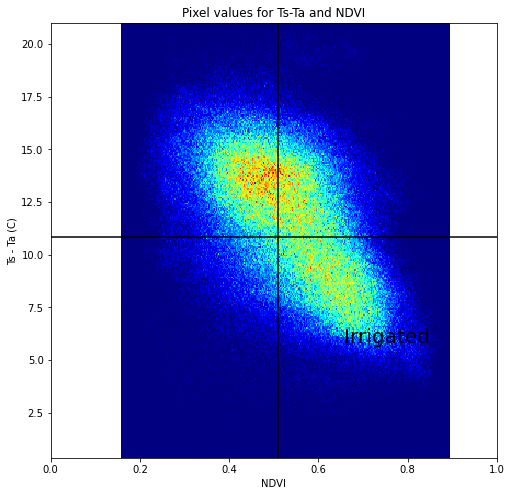

In [30]:
x = ds_ndvi.NDVI.values.flatten()[~np.isnan(ds_ndvi.NDVI.values.flatten())]
y = deltat.values.flatten()[~np.isnan(deltat.values.flatten())]

plt.figure(figsize=(8,8))
plt.hist2d(x, y, bins=(300, 300), cmap=plt.cm.jet)
plt.axhline(delta_threshold, c='black')
plt.axvline(ndvi_threshold, c='black')
plt.text(ndvi_threshold+0.15,delta_threshold-5, 'Irrigated', fontsize=20)
plt.xlim(0,1)
plt.xlabel('NDVI')
plt.ylabel('Ts - Ta (C)')
plt.title('Pixel values for Ts-Ta and NDVI');

In [20]:
# Compute clustering with Means
X = np.stack((x,y), axis=0).transpose()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled)
y_kmeans = kmeans.predict(X_scaled)

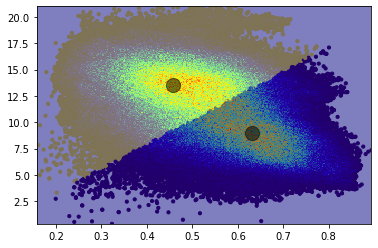

In [22]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10, cmap='viridis')
plt.hist2d(X[:, 0], X[:, 1], bins=(300, 300), cmap=plt.cm.jet, alpha=0.5)
centers_scaled = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [25]:
D = kmeans.predict(

Y = sklearn_unflatten(y_kmeans, ds_ndvi)
Y

<xarray.DataArray (x: 805, y: 1034)>
array([[nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  1., nan],
       [ 1.,  1.,  1., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 3.251e+06 3.251e+06 3.251e+06 ... 3.275e+06 3.275e+06
  * y        (y) float64 1.766e+06 1.766e+06 1.765e+06 ... 1.735e+06 1.735e+06

## Use thresholds to identify irrigation

In [26]:
#a=ds_ndvi.NDVI.where(ds_ndvi.NDVI>ndvi_threshold)
#b=a.where(deltat<delta_threshold)
#b=xr.where(b>0,1,0)

# add irrigated to cropmask classes
#c = xr.where((cm==1)&(b==1),2,cm)
c = xr.where((cm==1) & (Y == 1), 2, cm)

Load semi-annual geomedian to compare

In [27]:
gm = dc.load(product='gm_s2_semiannual', like=cm.geobox, time=time, measurements=['red','green','blue']).squeeze()

### Plot result

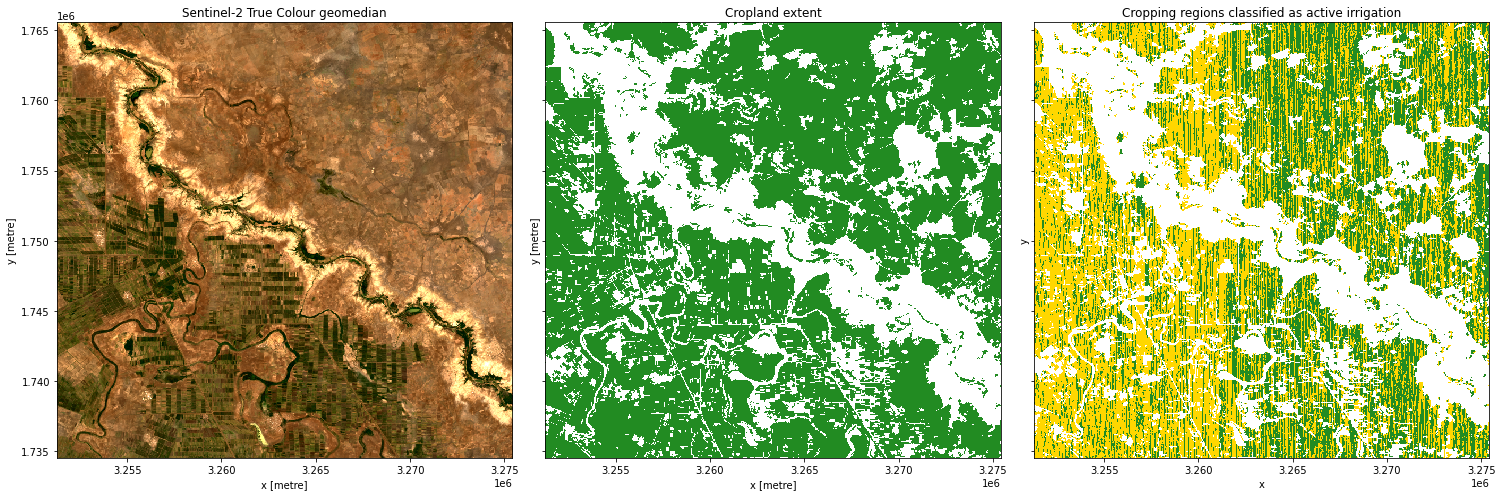

In [28]:
colours = ["white", "forestgreen", "gold"]

fig,ax=plt.subplots(1,3, figsize=(21,7), sharey=True)
rgb(gm, index=1, ax=ax[0])
cm.plot(ax=ax[1], add_colorbar=False, cmap=ListedColormap(colours[0:2]))
c.plot(add_colorbar=False, ax=ax[2], cmap=ListedColormap(colours))
ax[0].set_title('Sentinel-2 True Colour geomedian')
ax[1].set_title('Cropland extent')
ax[2].set_title("Cropping regions classified as active irrigation")
plt.tight_layout();

## Limitations

This method of calculating CWSI is based on several key assumptions:

* Air temperature is reasonably approximated by ERA5
* Land temperature is reasonably approximated by Landsat 8 Surface Temperature
* The minimum value of the temperature difference reasonably approximates the lower limit
* The maximum value of the temperature difference reasonably approximates the upper limit

Local minima and maxima vary depending on the loaded datasets. This means this method is not necessarily robust to changes in:

* Location of area of interest
* Size of area of interest
* Time period
* Severe fluctuations in either temperature dataset
* Method of resampling

As always, results should be interpreted with context and care.

## Next steps

* Investigate different CWSI behaviour between rainfed and irrigated cropping areas, potentially using the DE Africa crop mask and CHIRPS rainfall data

## References

Jackson, Ray D., Kustas, William P., and Choudhury, Bhaskar J. 1988. 'A Reexamination of the Crop Water Stress Index'. *Irrig Sci* 9:309-317

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [22]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [23]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-12-10'